In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor


In [9]:

# 1. Load datasets
eth_price = pd.read_csv("data/ETH_USD_11_20_2020-1_19_2021_historical_prices.csv", sep=";")
transactions = pd.read_csv("data/transactions_aggregated_21_22.csv")
validators = pd.read_csv("data/validators_aggregated_21_22.csv")

# 2. Clean and preprocess ETH price data
eth_price['datetime'] = pd.to_datetime(eth_price['timestamp'], errors='coerce')
eth_price = eth_price[['datetime', 'close']].dropna()
eth_price['close'] = pd.to_numeric(eth_price['close'], errors='coerce')
eth_price = eth_price.dropna()

# 3. Clean and preprocess transaction data
transactions['datetime'] = pd.to_datetime(transactions['datetime'], errors='coerce')
transactions['valueETH'] = pd.to_numeric(transactions['valueETH'], errors='coerce')
transactions['gas'] = pd.to_numeric(transactions['gas'], errors='coerce')
transactions = transactions.dropna(subset=['datetime', 'valueETH', 'gas'])

# Aggregate transactions by day
tx_daily = transactions.groupby(transactions['datetime'].dt.date).agg({
    'valueETH': 'sum',
    'gas': 'mean'
}).reset_index().rename(columns={'datetime': 'date'})

# 4. Clean and preprocess validator data
validators['datetime'] = pd.to_datetime(validators['datetime'], errors='coerce')
validators['valueETH'] = pd.to_numeric(validators['valueETH'], errors='coerce')
validators['gas'] = pd.to_numeric(validators['gas'], errors='coerce')
validators = validators.dropna(subset=['datetime', 'valueETH', 'gas'])

# Aggregate validator data by day
validators_daily = validators.groupby(validators['datetime'].dt.date).agg({
    'valueETH': 'sum',
    'gas': 'mean'
}).reset_index().rename(columns={'datetime': 'date'})
validators_daily.columns = ['date', 'validator_valueETH', 'validator_gas']

# 5. Merge all datasets
eth_price['date'] = eth_price['datetime'].dt.date
merged = eth_price.merge(tx_daily, on='date', how='left')
merged = merged.merge(validators_daily, on='date', how='left')

# Fill any remaining missing values with 0
merged.fillna(0, inplace=True)

# 6. Label ETH price into Low, Medium, High using quantiles
price_quantiles = merged['close'].quantile([0.33, 0.66])
def classify_price(price):
    if price <= price_quantiles[0.33]:
        return 'Low'
    elif price <= price_quantiles[0.66]:
        return 'Medium'
    else:
        return 'High'
merged['price_label'] = merged['close'].apply(classify_price)

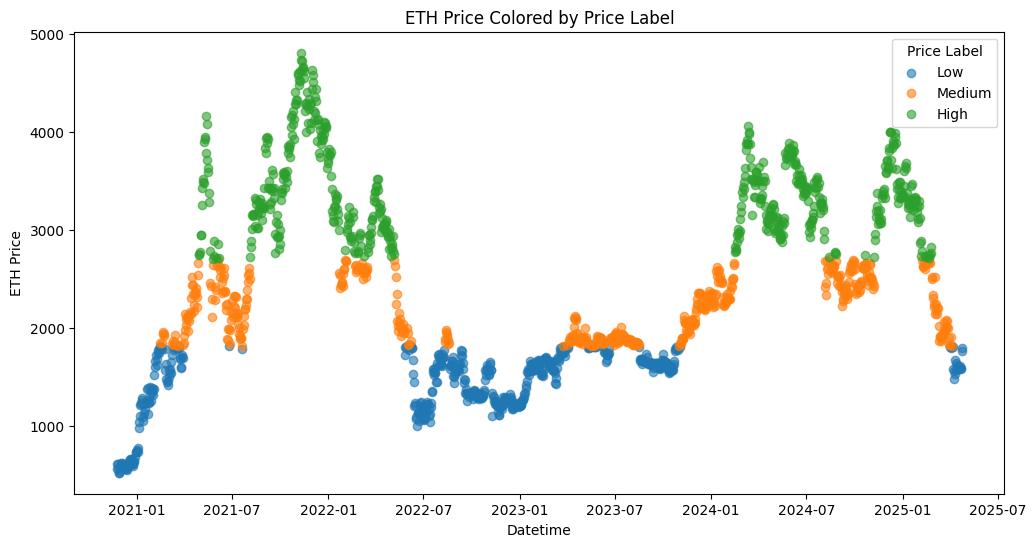

In [10]:
# Plot ETH price colored by price_label
plt.figure(figsize=(12, 6))
for label in merged['price_label'].unique():
    subset = merged[merged['price_label'] == label]
    plt.scatter(subset['datetime'], subset['close'], label=label, alpha=0.6)

plt.title('ETH Price Colored by Price Label')
plt.xlabel('Datetime')
plt.ylabel('ETH Price')
plt.legend(title='Price Label')
plt.show()

In [11]:
# 7. Add lag features (important temporal context)
merged['lag_close_1'] = merged['close'].shift(1).fillna(method='bfill')
merged['lag_close_2'] = merged['close'].shift(2).fillna(method='bfill')

# 8. Prepare features and labels
features = merged[['valueETH', 'gas', 'validator_valueETH', 'validator_gas', 'lag_close_1', 'lag_close_2']]
labels = merged['price_label']

# Encode class labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

/var/folders/9p/x79bt1w51lqcy7r6bzdq_8j80000gn/T/ipykernel_93570/718802877.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['lag_close_1'] = merged['close'].shift(1).fillna(method='bfill')
/var/folders/9p/x79bt1w51lqcy7r6bzdq_8j80000gn/T/ipykernel_93570/718802877.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['lag_close_2'] = merged['close'].shift(2).fillna(method='bfill')


In [22]:
knn_model = KNeighborsClassifier(n_neighbors=4,weights='distance')

knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

train_accuracy = knn_model.score(X_train, y_train)
eval_accuracy = knn_model.score(X_test, y_test)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Evaluation Accuracy: {eval_accuracy:.2f}")

Train Accuracy: 1.00
Evaluation Accuracy: 0.74


In [30]:
rf_model = RandomForestRegressor(n_estimators=10000, random_state=42,max_depth=2)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

train_accuracy = rf_model.score(X_train, y_train)
eval_accuracy = rf_model.score(X_test, y_test)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Evaluation Accuracy: {eval_accuracy:.2f}")

Train Accuracy: 0.86
Evaluation Accuracy: 0.82


Classification Report:
               precision    recall  f1-score   support

        High       0.97      0.92      0.95       118
         Low       0.98      0.97      0.97        92
      Medium       0.90      0.96      0.93       113

    accuracy                           0.95       323
   macro avg       0.95      0.95      0.95       323
weighted avg       0.95      0.95      0.95       323

Train Accuracy: 0.98
Evaluation Accuracy: 0.95


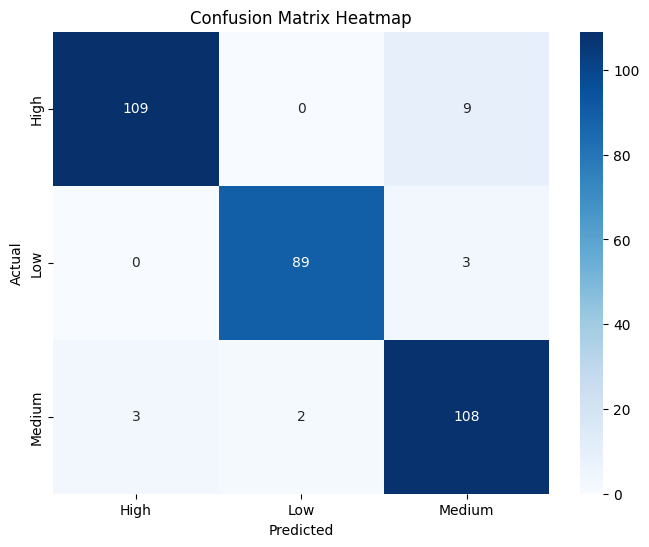

In [31]:
# 10. Train optimized Random Forest
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

# 11. Evaluate model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

train_accuracy = clf.score(X_train, y_train)
eval_accuracy = clf.score(X_test, y_test)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Evaluation Accuracy: {eval_accuracy:.2f}")

# 12. Plot confusion matrix as a heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
